# Study the distribution of IHC cases

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [16]:
ihc_reasons_file = Path('/mnt/rescomp/projects/IHC_Request/data/documents/IHC_reasons.csv')
ihc_reasons = pd.read_csv(ihc_reasons_file)
for r in sorted(set(ihc_reasons['IHC reason']), key=lambda r: int(r[0])):
    print(r + '\n')

10. Inflammation

1. A small length of cancer (e.g. for CV would be <1mm) of any cancer that we are fairly confident of calling cancer morphologically and are confirming with IHC

11. No time to review so IHC ordered pre emptively

2. Foci that are suspicious of are cancer but only consist of a couple of glands such that we are unlikely to definitively call the focus cancer, but if lack basal cells will be ASAP

3. Odd areas that we are not sure about morphologically what the diagnosis will ultimately be

4. A longer length of cancer which has an unusual appearance e.g. well differentiated cancer or cancer with very few well differentiated glands widely spaced by benign/stroma. Or variant/unusual e.g. clear cell change/atrophic variant/PIN like adenocarcinoma

5. Foci that are atypical but probably atrophic (benign)

6. Small glands around PIN ? small foci of invasion or ASAP or just PIN

9. Other and then explain in further details column



In [11]:
ihc_reasons['IHC_reason_num'] = ihc_reasons['IHC reason'].map(lambda r: int(r[0]))

Text(0.5, 1.0, 'IHC order reasons')

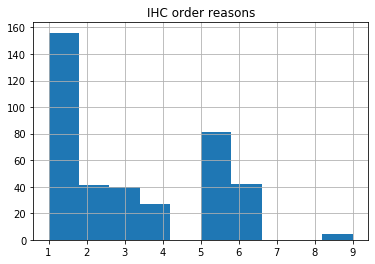

In [12]:
ihc_reasons['IHC_reason_num'].hist()
plt.title('IHC order reasons')